In [521]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
import distinctipy

from paolucci_functions import *

In [522]:
import os
import pandas as pd
import re
import numpy as np

def find_last_energy_value(filename):
    pattern = r"SCF Done:  E\(UPBE-PBE\) =  (-?\d+\.\d+)     A\.U\. after    \d+ cycles"
    last_energy = None
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                last_energy = float(match.group(1))
    
    return last_energy

def parse_frequencies(file_path):
    pattern = r'Frequencies\s+--\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)'  # regex to find desired lines
    frequencies = []

    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                freq_values = match.groups()
                frequencies.extend(freq_values)
    
    # Convert strings to floats and cutoff frequencies below 100 cm^-1
    no_low_freq = [float(x) for x in frequencies if float(x) >= 100]
    
    return no_low_freq

def calculate_zpe(frequencies):
    h = 6.62607015e-34  # Planck's constant in J*s
    cm_to_hz = 2.99793e10  # convert cm^-1 to Hz
    Na = 6.022e23  # Avogadro's number 
    
    frequencies_array = np.array(frequencies, dtype=float)
    zpe = 0.5 * (h/1000) * np.sum(frequencies_array) * cm_to_hz * Na  # zero point energy in units of kJ/mol
    
    return zpe

def parse_ligand_file(file_name, file_dir):
    # Remove the file extension
    base_name = os.path.splitext(file_name)[0]
    
    # Initialize ligand counts
    n_nh3 = 0
    n_h2o = 0
    n_c2h4 = 0
    
    # Define regular expressions for ligands
    nh3_pattern = re.compile(r'(\d+)_nh3')
    h2o_pattern = re.compile(r'(\d+)_h2o')
    c2h4_pattern = re.compile(r'(\d+)_c2h4')
    
    # Find all matches
    nh3_match = nh3_pattern.search(base_name)
    h2o_match = h2o_pattern.search(base_name)
    c2h4_match = c2h4_pattern.search(base_name)
    
    if nh3_match:
        n_nh3 = int(nh3_match.group(1))
    if h2o_match:
        n_h2o = int(h2o_match.group(1))
    if c2h4_match:
        n_c2h4 = int(c2h4_match.group(1))
    
    # The remaining part after the ligand patterns is the description
    description_parts = nh3_pattern.sub('', base_name)
    description_parts = h2o_pattern.sub('', description_parts)
    description_parts = c2h4_pattern.sub('', description_parts)
    description = description_parts.strip('_')
    
    # Read the log file to find the total energy and frequencies
    total_energy = find_last_energy_value(os.path.join(file_dir, file_name))
    frequencies = parse_frequencies(os.path.join(file_dir, file_name))
    zpe = calculate_zpe(frequencies)
    
    return n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, os.path.join(file_dir, file_name)

def extract_data_from_directory(base_dir):
    data = []
    
    for metal_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, metal_dir)):
            # Extract metal and charge information
            metal = ''.join([i for i in metal_dir if not i.isdigit()])
            charge = ''.join([i for i in metal_dir if i.isdigit()])
            
            for geometry_dir in os.listdir(os.path.join(base_dir, metal_dir)):
                if os.path.isdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                    geometry = geometry_dir.replace('_', ' ').capitalize()
                    
                    for ligand_file in os.listdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                        if ligand_file.endswith('.log'):  # replace with your file extension
                            n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, file_path = parse_ligand_file(ligand_file, os.path.join(base_dir, metal_dir, geometry_dir))
                            
                            data.append({
                                'Metal': metal.capitalize(),
                                'Charge': charge,
                                'Geometry': geometry,
                                'NH3': n_nh3,
                                'H2O': n_h2o,
                                'C2H4': n_c2h4,
                                'Description': description,
                                'Total Energy (Hartree)': total_energy,
                                'ZPE (kJ/mol)': zpe,
                                'File Path': file_path
                            })
    
    return pd.DataFrame(data)

# Set the base directory path
base_directory = '/Users/mohan/Desktop/Research/paolucci/data/freq'

# Extract the data into a dataframe
df = extract_data_from_directory(base_directory)

# Display the dataframe
df


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...
...,...,...,...,...,...,...,...,...,...,...
63,Co,2,Tetrahedral,0,0,4,,-1695.873238,552.205013,/Users/mohan/Desktop/Research/paolucci/data/fr...
64,Co,2,Tetrahedral,0,4,0,,-1687.370629,261.037222,/Users/mohan/Desktop/Research/paolucci/data/fr...
65,Co,2,Tetrahedral,0,0,3,1n2,-1617.357580,409.382533,/Users/mohan/Desktop/Research/paolucci/data/fr...
66,Co,2,Tetrahedral,4,0,0,,-1608.059847,408.647863,/Users/mohan/Desktop/Research/paolucci/data/fr...


In [523]:
import requests
from bs4 import BeautifulSoup

kb = 1.381e-23

h_p = 6.626e-34

Na = 6.022e23

R = 8.314

nh3_url = "https://janaf.nist.gov/tables/H-083.html"

h2o_url = "https://janaf.nist.gov/tables/H-064.html"

c2h4_url = "https://janaf.nist.gov/tables/C-128.html"

nh3_results = nist_collector(nh3_url)

h2o_results = nist_collector(h2o_url)

c2h4_results = nist_collector(c2h4_url)

zero_k_nh3_entropy = nh3_results[0][1]
zero_k_nh3_enthalpy = nh3_results[0][2]

zero_k_h2o_entropy = h2o_results[0][1]
zero_k_h2o_enthalpy = h2o_results[0][2]

zero_k_c2h4_entropy = c2h4_results[0][1]
zero_k_c2h4_enthalpy = c2h4_results[0][2]

In [524]:
import matplotlib.pyplot as plt

interp_temp = 378

# interpolate entropy and enthalpy over specified temp-range 

entropy_nh3 = cubicspline_interp(nh3_results[1:-1, 0], nh3_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_nh3 = cubicspline_interp(nh3_results[1:-1, 0], nh3_results[1:-1, 2], interp_temp)

entropy_h2o = cubicspline_interp(h2o_results[1:-1, 0], h2o_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_h2o = cubicspline_interp(h2o_results[1:-1, 0], h2o_results[1:-1, 2], interp_temp)

entropy_c2h4 = cubicspline_interp(c2h4_results[1:-1, 0], c2h4_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_c2h4 = cubicspline_interp(c2h4_results[1:-1, 0], c2h4_results[1:-1, 2], interp_temp)

In [525]:
def filter_dataframe(data: pd.DataFrame, metal:str, charge: int, geom: str) -> pd.DataFrame:
    """
    Returns dataframe with grouping specified by arguments
    """
    if geom:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge)) & (data['Geometry'] == geom)]
    else:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge))]
    
# new = filter_dataframe(data = df, metal = 'Cu', charge = 2, geom = 'Square planar')

new = filter_dataframe(data = df, metal = 'Pd', charge = 2, geom ="Square planar") # CHANGE GEOMETRY HERE

new.insert(10, "Entropy (kJ/mol*K)", None) # insert new, empty column at the end of the dataframe

new

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
23,Pd,2,Square planar,0,0,4,,-441.309638,555.996631,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
24,Pd,2,Square planar,2,0,1,n180,-318.693274,324.382673,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
25,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
26,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
27,Pd,2,Square planar,0,3,1,,-434.876410,335.413556,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
28,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
29,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
30,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
31,Pd,2,Square planar,0,4,0,,-432.719179,264.934707,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
32,Pd,2,Square planar,0,1,2,n90,-360.618231,340.798166,/Users/mohan/Desktop/Research/paolucci/data/fr...,None


In [540]:
init_nh3 = 1 # CHANGE INIT NUM NH3 HERE
final_nh3 = 1 # CHANGE FINAL NUM NH3 HERE

rxn_df = new[new['NH3'].isin([init_nh3, final_nh3])]

rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
25,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
26,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
28,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
29,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
30,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
46,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
48,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
52,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,None


In [541]:
def reference_energy(reduced_data: pd.DataFrame, start_nh3:int) -> np.float64:
    """
    Returns lowest energy associated with complete saturation of ammonia (lowest if comparing b/t geometries)
    """
    intermediate = reduced_data[(reduced_data['NH3'] == start_nh3)]
    return intermediate['Total Energy (Hartree)'].values

def reference_entropy(reduced_data: pd.DataFrame, start_nh3:int) -> np.float64:
    """
    Returns energy associated with complete saturation of ammonia
    """
    intermediate = reduced_data[(reduced_data['NH3'] == start_nh3)]
    return intermediate["Entropy (kJ/mol*K)"].values

def reference_energy_entropy(reduced_data: pd.DataFrame, start_nh3:int) -> np.float64:
    """
    Returns lowest energy associated with complete saturation of ammonia and the entropy of that species
    """
    intermediate = reduced_data[(reduced_data['NH3'] == start_nh3)]
    min_index = intermediate['Total Energy (Hartree)'].idxmin() # lowest energy of full saturation with NH3 if mult. geometries
    return intermediate.loc[min_index, 'Total Energy (Hartree)'], intermediate.loc[min_index, 'Entropy (kJ/mol*K)']

e_nh3 = -56.4923518650 # hartree
e_h2o = -76.3434909651 # hartree
e_c2h4 = -78.4923922995 # hartree

har_to_kjmol = 2625.5

In [542]:
for row in rxn_df.itertuples(index=True):
    
    s_trans, s_vib, s_rot = calc_entropy(infile = row[10], temperature = interp_temp)
    
    total_entropy = (s_trans + s_vib + s_rot)

    rxn_df.at[row[0], 'Entropy (kJ/mol*K)']  = total_entropy/1000 # total_entropy is in J/mol*K so divide to get kJ

rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
25,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.3876396129711158
26,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.40106501169166553
28,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962
29,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943
30,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323
46,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556
48,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237
52,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175


In [543]:
intermediate = rxn_df[(rxn_df['NH3'] == init_nh3)]

min_index = intermediate['Total Energy (Hartree)'].idxmin() # lowest energy of full saturation with NH3 if mult. geometries

init_cond = intermediate.loc[min_index]

rxn_df.reset_index(drop=True, inplace=True) # reset indices for plotting more easily later

my_colors = distinctipy.get_colors(rxn_df.shape[0], pastel_factor=1.0)

my_colormap = ListedColormap(my_colors)

rxn_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
0,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.3876396129711158
1,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.40106501169166553
2,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962
3,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943
4,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323
5,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556
6,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237
7,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175


In [544]:
# for row in rxn_df.itertuples(index=True):
#     # row[4] = # NH3, row[5] = # H2O, row[6] = # C2H4, row[8] = Total Energy, row[11] = Entropy
#     print(row[11])

for i in range(rxn_df.shape[0]):
    delta_e = (rxn_df.loc[i, 'Total Energy (Hartree)'] - ((rxn_df.loc[i, 'H2O'] - init_cond['H2O']) * e_h2o) - ((rxn_df.loc[i, 'C2H4'] - init_cond['C2H4']) * e_c2h4)
                - ((rxn_df.loc[i, 'NH3'] - init_cond['NH3']) * e_nh3) - init_cond['Total Energy (Hartree)']) * har_to_kjmol
    rxn_df.loc[i, 'Delta E (kJ/mol)'] = delta_e


delta_s = (rxn_df['Entropy (kJ/mol*K)'].apply(lambda x: x - init_cond['Entropy (kJ/mol*K)'])) 

rxn_df.loc[rxn_df.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row

rxn_df

/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_80795/2276159470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxn_df.loc[i, 'Delta E (kJ/mol)'] = delta_e
/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_80795/2276159470.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxn_df.loc[rxn_df.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.3876396129711158,147.837125,-0.091493
1,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.40106501169166553,160.580525,-0.078067
2,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962,-16.834988,-0.013820
3,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943,-21.354828,-0.064544
4,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323,0.000000,0.000000
5,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556,-24.997434,-0.033654
6,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237,-42.971114,-0.042400
7,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175,-8.624076,-0.054216


In [545]:
descending_df = rxn_df.sort_values('Delta E (kJ/mol)')

new_descending_df = descending_df['Total Energy (Hartree)'] * har_to_kjmol

descending_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
6,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237,-42.971114,-0.042400
5,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556,-24.997434,-0.033654
3,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943,-21.354828,-0.064544
2,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962,-16.834988,-0.013820
7,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175,-8.624076,-0.054216
4,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323,0.000000,0.000000
0,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.3876396129711158,147.837125,-0.091493
1,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.40106501169166553,160.580525,-0.078067


In [546]:
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.colors as mcolors


class single_vals():
    def __init__(self, data, temperature:np.ndarray, p_nh3:np.ndarray, p_h2o:np.ndarray, p_c2h4:np.ndarray, in_cond:pd.DataFrame):
            self.data = data 
            self.temperature = temperature
            self.p_nh3 = p_nh3
            self.p_h2o = p_h2o
            self.p_c2h4 = p_c2h4
            self.nh3_i = in_cond['NH3']
            self.h2o_i = in_cond['H2O']
            self.c2h4_i = in_cond['C2H4']

    def no_mu(self):
        
        dE_TdS = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values):
            # delta[0] = dE --> delta[1] = dS
            # dE - TdS
            dE_TdS.append(delta[0] - (self.temperature * delta[1]))
        
        return dE_TdS

    def plot_no_mu(self, outfile = None):

        dE_TdS = self.no_mu()

        colors = ['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e']

        linestyles = ['-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--'] # dashed lines for one type of geom

        # Iterate over rows
        
        fig, ax = plt.subplots()

        for row in self.data.itertuples(index=True):
            linestyle = '--' if row[3] == 'Tetrahedral' else '-'
            Geom = 'Tet' if row[3] == 'Tetrahedral' else 'SqP'
            # ax.plot(self.temperature, dE_TdS[row[0]]) # , color = colors[row[0]]
            ax.plot(self.temperature, dE_TdS[row[0]], label = ' '+str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[6])+" C2H4 "+str(row[7]), linestyle = linestyle) # , color = colors[row[0]]
            # print(row[4], "NH3", row[5], "H2O", row[7], 'dE =', row[-1])

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta E - T \Delta S  \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        plt.show();


    def plot_no_mu_single(self, index, outfile = None):
        dE_TdS = self.no_mu()

        fig, ax = plt.subplots()

        interest = self.data.loc[index, :]
        
        ax.plot(self.temperature, dE_TdS[index], label = interest['Geometry']+' '+str(interest['NH3'])+r"N$H_3$ "+str(interest['H2O'])+r"H$_2$O "+str(interest['Description'])+r" $\Delta$ E = "+str(int(interest['Delta E (kJ/mol)'])))

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta E - T \Delta S  \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.2), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')

        plt.show();
        
    def vary_temp(self):

        
        mu_nh3 = (enthalpy_nh3 - zero_k_nh3_enthalpy) - (self.temperature * entropy_nh3) + (0.008314 * self.temperature * np.log(self.p_nh3))
        mu_h2o = (enthalpy_h2o - zero_k_h2o_enthalpy) - (self.temperature * entropy_h2o) + (0.008314 * self.temperature * np.log(self.p_h2o))
        mu_c2h4 = (enthalpy_c2h4 - zero_k_c2h4_enthalpy) - (self.temperature * entropy_c2h4) + (0.008314 * self.temperature * np.log(self.p_c2h4))

        dE_TdS_mu = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = yH2O on Pd_f --> delta[3] = zC2H4 on Pd_f --> delta[4] = xNH3 on Pd_f
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1]) - ((delta[2] - self.h2o_i) * mu_h2o) - ((delta[3] - self.c2h4_i) * mu_c2h4) - ((delta[4] - self.nh3_i) * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4
    
    def plot_vary_temp(self, outfile = None):
            
        dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_temp()
        colors = ['#51a885', 'r', '#ed8c37', '#f5a396', '#986b9b', '#267a9e']

        fig, ax = plt.subplots()

        for row in self.data.itertuples(index=True):
            linestyle = '--' if row[3] == 'Tetrahedral' else '-'
            ax.plot(self.temperature, dE_TdS_mu[row[0]], label = ' '+str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[6])+" C2H4 "+str(row[7]), linestyle = linestyle) # , color = colors[row[0]]
            

        ax.set_xlabel("Temperature [K]")
        ax.set_ylabel(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")
        plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
        plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}: "+r"$P_{NH_3} = "+str(self.p_nh3)+r"\; atm \;  P_{H_2 O}$ = "+str(self.p_h2o)+" atm "+r"$P_{C_2 H_4}$ = "+str(self.p_c2h4)+" atm")
        
        if outfile:
            plt.savefig(outfile, dpi = 400, bbox_inches='tight')
        
        plt.show();

    def vary_temp_ph2o(self):
        mu_h2o = np.zeros((len(self.temperature), len(self.p_h2o)), dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_nh3 = np.zeros_like(self.temperature, dtype = np.float32) # varying temp along row; constant pres. along row
        mu_c2h4 = np.zeros_like(self.temperature, dtype = np.float32) # constant temp along row; constant pres. down column 
        
        for t, temp in enumerate(self.temperature):
            for p, pres in enumerate(self.p_h2o):
                mu_h2o[t][p] = (enthalpy_h2o[t] - zero_k_h2o_enthalpy) - (temp * entropy_h2o[t]) + (0.008314 * temp * np.log(pres))
                mu_nh3[t] = (enthalpy_nh3[t] - zero_k_nh3_enthalpy) - (temp * entropy_nh3[t]) + (0.008314 * temp * np.log(self.p_nh3))
                mu_c2h4[t] = (enthalpy_c2h4[t] - zero_k_c2h4_enthalpy) - (temp * entropy_c2h4[t]) + (0.008314 * temp * np.log(self.p_c2h4))

        dE_TdS_mu = []

        mu_nh3 = mu_nh3[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)
        mu_c2h4 = mu_c2h4[:, np.newaxis]  # Shape changes from (len{temp}, ) to (len{temp}, 1)

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = yH2O on Pd_f --> delta[3] = zC2H4 on Pd_f --> delta[4] = xNH3 on Pd_f
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1])[:, np.newaxis] - ((delta[2] - self.h2o_i) * mu_h2o) - ((delta[3] - self.c2h4_i) * mu_c2h4) - ((delta[4] - self.nh3_i) * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4

    def plot_vary_temp_ph2o_noG(self, outfile=None):
            dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_temp_ph2o()

            P, T = np.meshgrid(self.p_h2o, self.temperature)

            min_values = np.minimum.reduce(dE_TdS_mu)

            labels = np.argmin(dE_TdS_mu, axis=0)  # Find minimum value at each index i, j of the tensor

            integer_range = np.arange(0, len(self.data)+1)  # delete if needed
            
            # Use a general colormap for the labels
            cmap = plt.get_cmap('tab20', len(integer_range)) 

            norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(integer_range) + 0.5), ncolors=len(integer_range)) # delete if needed

            # Plotting
            fig, axs = plt.subplots(figsize=(10, 5))

            # Extract tick labels from self.data
            tick_labels = []
            for row in self.data.itertuples(index=True):
                label = f"{row[3]} \n {row[4]}NH3"
                tick_labels.append(label)

            # Create contour plot for the labels with the general colormap
            contour_labels = axs.contourf(P, T, labels, levels=np.arange(len(integer_range) + 1) - 0.5, cmap=cmap, norm = norm) # delete levels and norm if needed
            cbar_labels = fig.colorbar(contour_labels, ticks=np.arange(len(integer_range)), ax=axs, orientation='horizontal') # delete ticks argument if needed

            axs.set_xlabel(r'log $\mathbf{_{10} \left(  \frac{P_{H_2O}}{P \degree} \right) }$', fontsize = 14, weight = 'bold')
            axs.set_xscale('log')
            axs.set_ylabel('Temperature [K]', fontsize = 14, weight = 'bold')

            # axs.axhline(y=378, color='k', linestyle='-') # dashed line at 378 K
            # axs.axvline(x=0.0296, color='k', linestyle='dotted', label = '3 kPa') # dashed line at 3 kPa 
            # axs.axvline(x=0.0986923 , color='k', linestyle='dashed', label = '10 kPa') # dashed line at 10 kPa 
            # axs.axvline(x=0.1382, color='k', linestyle='dashdot', label = '14 kPa') # dashed line at 14 kPa 
            # axs.legend(bbox_to_anchor=(1.15, 0.6), loc='right', frameon=False) # CHANGE THIS BBOX

            # Adjust layout
            plt.tight_layout()
            
            axs.minorticks_off()
            
            plt.suptitle(r"Free Energy of "+self.data['Metal'][0]+r"$\bf{^{"+self.data['Charge'][0]+r"+} \; P_{NH_3}}$ = "+str(self.p_nh3)+" atm"+ " "+r"$\bf{P_{C_2 H_4}}$ = "+str(self.p_c2h4)+" atm", fontweight = 'bold', y = 1.02)

            if outfile:
                plt.savefig(outfile, dpi=400, bbox_inches='tight')

            # Show plot
            plt.show()
#-------------------------------------------------------------------------------- */


In [561]:
h2o_pressure = 14 # WATER PRESSURE 

c2h4_pressure = 0.25 # kPa 

kpa_to_atm = 0.00986923 # 1 kPa = 0.00986923 atm

wisc = single_vals(data = rxn_df, temperature = 378, p_nh3 = 0.05, p_h2o = (h2o_pressure * kpa_to_atm), p_c2h4 = (c2h4_pressure * kpa_to_atm), in_cond=init_cond)

dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = wisc.vary_temp()

dE_TdS_mu

rxn_df['Delta G (kJ/mol)'] = dE_TdS_mu

rxn_df

/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_80795/3403379408.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rxn_df['Delta G (kJ/mol)'] = dE_TdS_mu


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K),Delta G (kJ/mol)
0,Pd,2,Square planar,1,0,2,n90,-340.797516,376.668381,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.3876396129711158,147.837125,-0.091493,90.714926
1,Pd,2,Square planar,1,0,2,n180,-340.792663,373.478670,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.40106501169166553,160.580525,-0.078067,98.383525
2,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962,-16.834988,-0.013820,-35.294096
3,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943,-21.354828,-0.064544,-68.006584
4,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323,0.000000,0.000000,0.000000
5,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556,-24.997434,-0.033654,-35.959470
6,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237,-42.971114,-0.042400,-74.310118
7,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175,-8.624076,-0.054216,-35.496711


In [562]:
plot_df = rxn_df[rxn_df['Delta G (kJ/mol)'] < 20].copy().reset_index(drop=True)

#  plot_df = rxn_df.drop(11).reset_index(drop=True)

plot_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K),Delta G (kJ/mol)
0,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962,-16.834988,-0.013820,-35.294096
1,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943,-21.354828,-0.064544,-68.006584
2,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323,0.000000,0.000000,0.000000
3,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556,-24.997434,-0.033654,-35.959470
4,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237,-42.971114,-0.042400,-74.310118
5,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175,-8.624076,-0.054216,-35.496711


In [563]:
if h2o_pressure == 3:
    plot_color = 'cornflowerblue'
elif h2o_pressure == 10:
    plot_color = 'mediumblue'
elif h2o_pressure == 14:
    plot_color = 'midnightblue'

# Function to create the 'Species' string in LaTeX format
def create_species(row):
    species = row['Metal']
    if row['NH3'] > 0:
        species += f"(NH_{{3}})_{{{row['NH3']}}}"
    if row['H2O'] > 0:
        species += f"(H_{{2}}O)_{{{row['H2O']}}}"
    if row['C2H4'] > 0:
        species += f"(C_{{2}}H_{{4}})_{{{row['C2H4']}}}"
    return species

# Create the 'Species' column
plot_df['Species'] = plot_df.apply(create_species, axis=1)

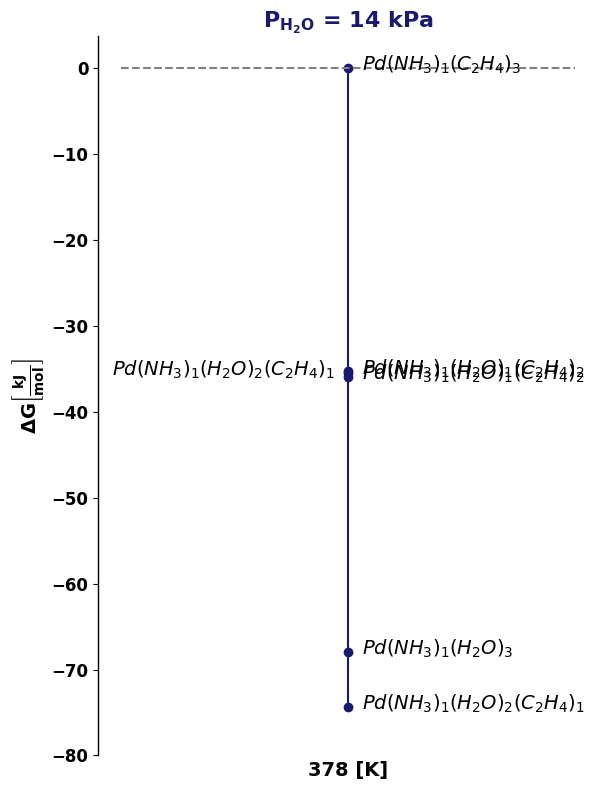

In [564]:
# Initialize the first text position to right (1)
# Make a copy of the DataFrame to avoid SettingWithCopyWarning

# plot_color = 'darkgreen' # This is for the NH3 cascade iamge

plot_df = plot_df.copy()

plot_df['text_position'] = 1  # Default: right side

# Sort the dataframe by Delta G values so we can alternate positions starting from the most positive value
plot_df = plot_df.sort_values(by='Delta G (kJ/mol)', ascending=False).reset_index(drop=True)

# Loop through Delta G values and alternate positions for values within 3 kJ/mol of each other
for i in range(1, len(plot_df)):
    # Check if the current value is within 3 kJ/mol of the previous value
    if abs(plot_df['Delta G (kJ/mol)'][i] - plot_df['Delta G (kJ/mol)'][i-1]) <= 3:
        # Alternate the text position: right (1) -> left (-1), and vice versa
        plot_df.at[i, 'text_position'] = plot_df['text_position'][i-1] * -1
    else:
        # If not within 3 kJ/mol, reset to right (1)
        plot_df.at[i, 'text_position'] = 1

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 8))

# Plot vertical lines and points
ax.plot([1] * len(plot_df), plot_df['Delta G (kJ/mol)'], marker='o', linestyle='-', color=plot_color) # uncomment this for water pressure variation

# Customize the plot
ax.set_ylabel(r'$\mathbf{ \Delta G \left[ \frac{kJ}{mol} \right] }$', fontsize=14)
ax.set_xticks([])  # Remove x-axis ticks since we only need one vertical line
ax.set_xlabel('378 [K]', fontsize=14, weight='bold')
ax.set_title(r'$\mathbf{ P_{H_2 O} }$ = ' + str(h2o_pressure) + ' kPa', fontsize=16, color=plot_color, weight = 'bold') # uncomment this for water pressure variation 
# ax.set_title(f'{init_nh3} NH3', fontsize=16, color=plot_color, weight = 'bold')

# Add a horizontal reference line at 0 ΔG
ax.axhline(y=0, color='gray', linestyle='--')

# Annotate each point (species) with LaTeX-formatted labels, alternating positions where necessary
for i, txt in enumerate(plot_df['Species']):
    # Determine text offset and horizontal alignment based on position (right or left)
    offset = 10 if plot_df['text_position'][i] == 1 else -10
    ha = 'left' if offset == 10 else 'right'
    
    # Annotate the plot at the corresponding position
    ax.annotate(f"${txt}$", (1, plot_df['Delta G (kJ/mol)'][i]), textcoords="offset points", 
                xytext=(offset, -2), ha=ha, fontsize=14) # chemical species fontsize changed here

# Remove top, right, and bottom borders (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Make the left spine move inward (to the right)
ax.spines['left'].set_position(('axes', -0.05))  # Moves the spine 5% inward

# Optionally, increase the visibility of the left border
ax.spines['left'].set_linewidth(1)

every_kjmol = 10
min_free_energy = -70

plt.yticks(fontsize=12, weight = 'bold')  # Adjust the fontsize as needed (e.g., 12, 14)


# Set y-axis tick marks every 5 kJ/mol
# ax.set_yticks(range(int(plot_df['Delta G (kJ/mol)'].min()) - every_kjmol, int(plot_df['Delta G (kJ/mol)'].max()) + every_kjmol, every_kjmol)) # y-axis based on single df
ax.set_yticks(range(int(min_free_energy - every_kjmol), int(0) + every_kjmol, every_kjmol)) # define global minimum 

# Display the plot
plt.tight_layout()
plt.savefig(f"/Users/mohan/Desktop/{init_nh3}_nh3_{h2o_pressure}_kPaH2O.svg", dpi = 500)
plt.show();

In [565]:
descending_df = plot_df.sort_values('Delta G (kJ/mol)')

descending_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K),Delta G (kJ/mol),Species,text_position
5,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237,-42.971114,-0.042400,-74.310118,Pd(NH_{3})_{1}(H_{2}O)_{2}(C_{2}H_{4})_{1},1
4,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943,-21.354828,-0.064544,-68.006584,Pd(NH_{3})_{1}(H_{2}O)_{3},1
3,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556,-24.997434,-0.033654,-35.959470,Pd(NH_{3})_{1}(H_{2}O)_{1}(C_{2}H_{4})_{2},1
2,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175,-8.624076,-0.054216,-35.496711,Pd(NH_{3})_{1}(H_{2}O)_{2}(C_{2}H_{4})_{1},-1
1,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962,-16.834988,-0.013820,-35.294096,Pd(NH_{3})_{1}(H_{2}O)_{1}(C_{2}H_{4})_{2},1
0,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323,0.000000,0.000000,0.000000,Pd(NH_{3})_{1}(C_{2}H_{4})_{3},1


In [566]:
import numpy as np
import pandas as pd

def compute_boltzmann_factors(df, temperature):
    """
    Computes the Boltzmann factor for the 'Delta G (kJ/mol)' column in the dataframe.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with a column titled "Delta G (kJ/mol)".
    temperature (float): Temperature in Kelvin.

    Returns:
    pd.Series: A series with the normalized Boltzmann factors.
    """
    R = 8.3145e-3  # Gas constant in kJ/mol·K
    
    # Compute the exponentials
    exp_factors = np.exp(-df["Delta G (kJ/mol)"] / (R * temperature))
    
    # Normalize by the sum of the exponentials
    boltzmann_factors = exp_factors / exp_factors.sum()
    
    return boltzmann_factors

# Compute the Boltzmann factors and assign to 'Probability' column
plot_df["Probability"] = compute_boltzmann_factors(plot_df, temperature=interp_temp)  

plot_df["Probability"] * 100 

0    4.750356e-09
1    3.579233e-04
2    3.817579e-04
3    4.423171e-04
4    1.186091e+01
5    8.813791e+01
Name: Probability, dtype: float64

In [567]:
plot_df

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K),Delta G (kJ/mol),Species,text_position,Probability
0,Pd,2,Square planar,1,0,3,,-419.346217,518.260738,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4791324545698323,0.000000,0.000000,0.000000,Pd(NH_{3})_{1}(C_{2}H_{4})_{3},1,4.750356e-11
1,Pd,2,Square planar,1,1,2,c2h4180apart,-417.203728,443.621472,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4653124269520962,-16.834988,-0.013820,-35.294096,Pd(NH_{3})_{1}(H_{2}O)_{1}(C_{2}H_{4})_{2},1,3.579233e-06
2,Pd,2,Square planar,1,2,1,1_c2h180apart,-415.051699,370.111142,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4249167896599175,-8.624076,-0.054216,-35.496711,Pd(NH_{3})_{1}(H_{2}O)_{2}(C_{2}H_{4})_{1},-1,3.817579e-06
3,Pd,2,Square planar,1,1,2,c2h490apart,-417.206837,443.258961,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4454789056238556,-24.997434,-0.033654,-35.959470,Pd(NH_{3})_{1}(H_{2}O)_{1}(C_{2}H_{4})_{2},1,4.423171e-06
4,Pd,2,Square planar,1,3,0,,-412.907647,299.564815,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4145888619396943,-21.354828,-0.064544,-68.006584,Pd(NH_{3})_{1}(H_{2}O)_{3},1,1.186091e-01
5,Pd,2,Square planar,1,2,1,1_c2h90apart,-415.064781,372.019690,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4367325802095237,-42.971114,-0.042400,-74.310118,Pd(NH_{3})_{1}(H_{2}O)_{2}(C_{2}H_{4})_{1},1,8.813791e-01
